In [348]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mplcyberpunk
from scipy import stats
from sklearn import linear_model, model_selection, metrics, preprocessing, feature_selection, decomposition, tree, ensemble
import numpy as np
import category_encoders as ce
from datetime import datetime
import ptitprince as pt
import logging
import warnings
warnings.filterwarnings('ignore')
plt.style.use('cyberpunk')

In [349]:
df = pd.read_csv('data/anime.csv')
df.head()

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


In [350]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12294 entries, 0 to 12293
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   anime_id  12294 non-null  int64  
 1   name      12294 non-null  object 
 2   genre     12232 non-null  object 
 3   type      12269 non-null  object 
 4   episodes  12294 non-null  object 
 5   rating    12064 non-null  float64
 6   members   12294 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 672.5+ KB


In [351]:
print('Количество дубликатов:', df.drop('anime_id', axis=1).duplicated().sum())
df[['genre', 'type']] = df[['genre', 'type']].fillna('None')
df['episodes'] = df['episodes'].replace('Unknown', np.nan)
df = df.dropna(axis=0)
df['episodes'] = df['episodes'].astype('int')

Количество дубликатов: 0


In [352]:
genres_col = set()
def get_genres(value): 
    for i in value.split(', '):
        genres_col.add(i)

df['genre'].apply(get_genres)
for i in genres_col:
    df[i] = df['genre'].apply(lambda x: 1 if i in x else 0)

genre_series = pd.Series(data=[df[i].sum() for i in genres_col], index=genres_col).sort_values(ascending=False)

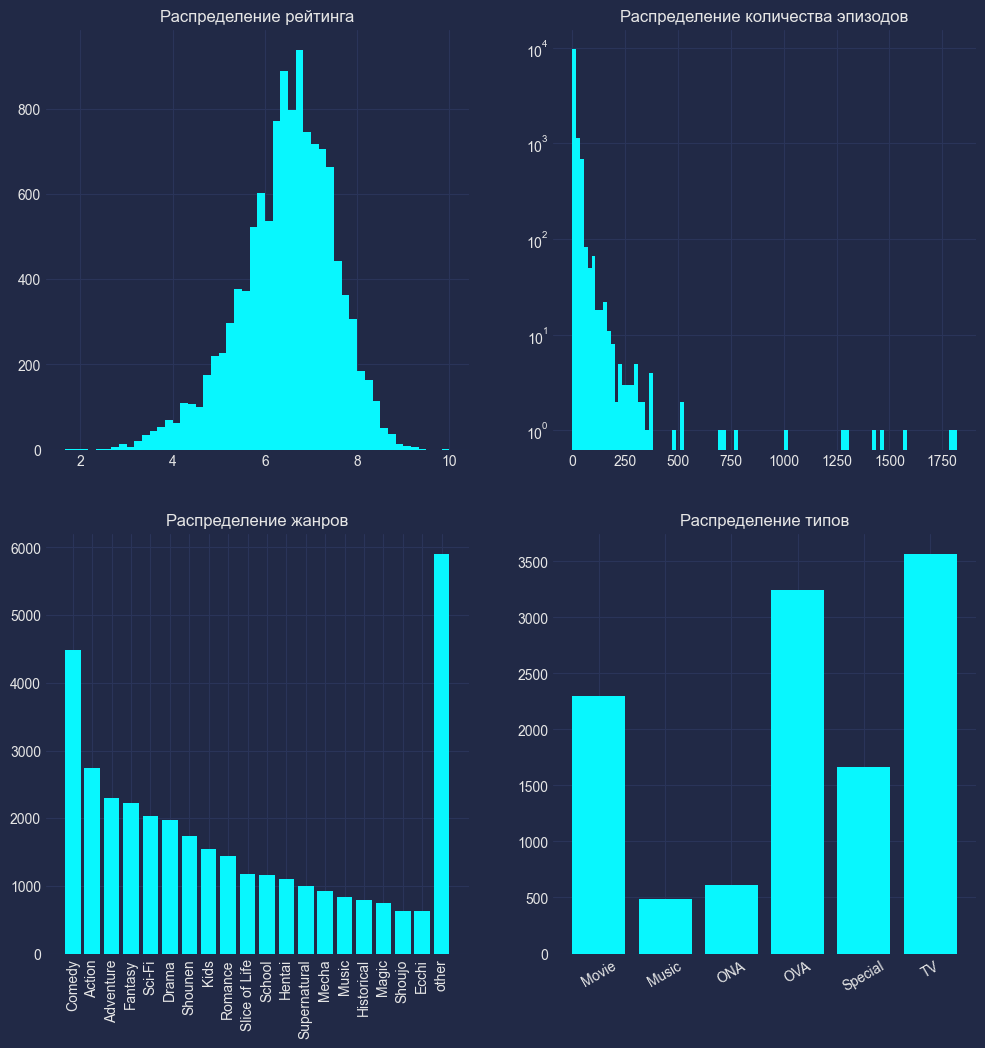

In [353]:
fig, ax = plt.subplots(2, 2, figsize=(12, 12))
    # гистограмма распределения рейтинга
ax[0, 0].hist(df['rating'], bins=50)
ax[0, 0].set_title('Распределение рейтинга')
    # гистограмма распределения количества эпизодов
ax[0, 1].hist(df['episodes'], bins=100, log=True)
ax[0, 1].set_title('Распределение количества эпизодов')
    # столбчатая диаграмма распределения жанров
data_bar = genre_series[genre_series > 600]
data_bar.loc['other'] = genre_series[genre_series < 600].sum()
ax[1, 0].bar(data_bar.index, data_bar.values)
ax[1, 0].set_xticklabels(ax[1, 0].get_xticklabels(), rotation=90, fontsize='medium')
ax[1, 0].set_title('Распределение жанров')
    # столбчатая диаграмма распределения типов
anime_types = df.groupby('type')['anime_id'].count()
ax[1, 1].bar(anime_types.index, anime_types.values)
ax[1, 1].set_xticklabels(ax[1, 1].get_xticklabels(), rotation=30)
ax[1, 1].set_title('Распределение типов');

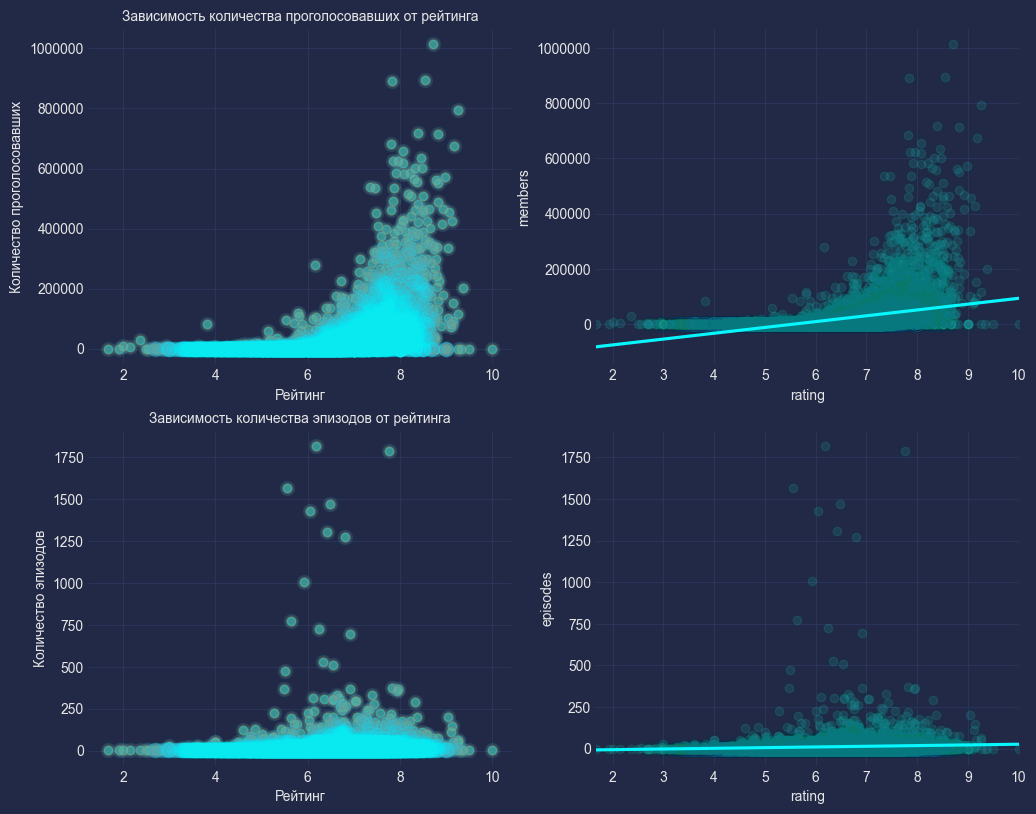

In [354]:
plt.figure(figsize=(12, 20))
    # построение графика зависимости количества проголосовавших от рейтинга
plt.subplot(4, 2, 1)
plt.title('Зависимость количества проголосовавших от рейтинга', fontsize='medium')
plt.ticklabel_format(style='plain')
plt.scatter(df['rating'], df['members'], alpha=0.5)
plt.ylabel('Количество проголосовавших')
plt.xlabel('Рейтинг')
mplcyberpunk.make_scatter_glow(n_glow_lines=7, diff_dotwidth=1.2, alpha=0.5)

plt.subplot(4, 2, 2)
plt.ticklabel_format(style='plain')
sns.regplot(df['rating'], df['members'], scatter=False)
plt.scatter(df['rating'], df['members'], alpha=0.1)
mplcyberpunk.make_scatter_glow(n_glow_lines=7, diff_dotwidth=1.2, alpha=0.05)
    # построение графика зависимости количества эпизодов от рейтинга
plt.subplot(4, 2, 3)
plt.title('Зависимость количества эпизодов от рейтинга', fontsize='medium')
plt.scatter(df['rating'], df['episodes'].replace('Unknown', 0).astype('int'), alpha=0.5)
plt.ylabel('Количество эпизодов')
plt.xlabel('Рейтинг')
mplcyberpunk.make_scatter_glow(n_glow_lines=7, diff_dotwidth=1.2, alpha=0.5)

plt.subplot(4, 2, 4)
sns.regplot(df['rating'], df['episodes'], scatter=False)
plt.scatter(df['rating'], df['episodes'], alpha=0.1)
mplcyberpunk.make_scatter_glow(n_glow_lines=7, diff_dotwidth=1.2, alpha=0.05)


data_movie p-value: 2.981815378175234e-15
Распределение не нормальное
data_tv p-value: 2.3221507575273636e-20
Распределение не нормальное
data_ova p-value: 1.466574359512956e-14
Распределение не нормальное

p-value: 1.0
p-значение больше, чем заданный уровень значимости 0.05. У нас нет оснований отвергнуть нулевую гипотезу.

p-value: 0.3979994020844686
p-значение больше, чем заданный уровень значимости 0.05. У нас нет оснований отвергнуть нулевую гипотезу.


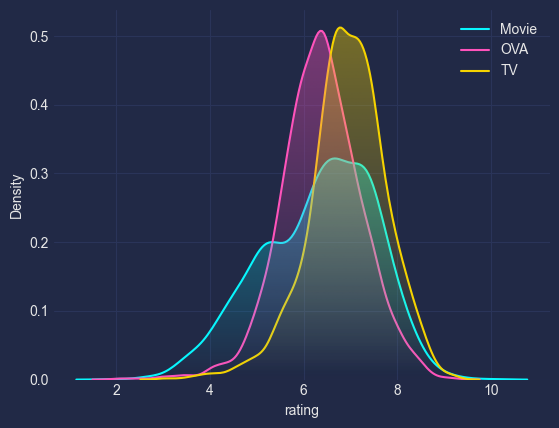

In [355]:
alpha = 0.05

data_movie = df[df['type'] == 'Movie']['rating']
data_tv = df[df['type'] == 'TV']['rating']
data_ova = df[df['type'] == 'OVA']['rating']

for i in [('data_movie', data_movie), ('data_tv', data_tv), ('data_ova', data_ova)]:
    result = stats.shapiro(i[1])
    print(f'{i[0]} p-value:', result[1])
    if result[1] <= alpha:
        print('Распределение не нормальное')
    else:
        print('Распределение нормальное')

result = stats.mannwhitneyu(data_movie, data_tv, alternative = 'greater')
print('\np-value:', result[1])
if result[1] <= alpha:
    print('p-значение меньше, чем заданный уровень значимости {:.2f}. Отвергаем нулевую гипотезу.'.format(alpha))
else:
    print('p-значение больше, чем заданный уровень значимости {:.2f}. У нас нет оснований отвергнуть нулевую гипотезу.'.format(alpha))

result = stats.mannwhitneyu(data_movie, data_ova)
print('\np-value:', result[1])
if result[1] <= alpha:
    print('p-значение меньше, чем заданный уровень значимости {:.2f}. Отвергаем нулевую гипотезу.'.format(alpha))
else:
    print('p-значение больше, чем заданный уровень значимости {:.2f}. У нас нет оснований отвергнуть нулевую гипотезу.'.format(alpha))

sns.kdeplot(data_movie, label='Movie')
sns.kdeplot(data_ova, label='OVA')
sns.kdeplot(data_tv, label='TV')
plt.legend()

mplcyberpunk.add_gradient_fill(alpha_gradientglow=0.4, gradient_start='zero')

* Распределение рейтинга в формате фильма меньше, чем подобное распределение для TV формата.
* Распределение рейтинга в формате фильма сопоставимо с подобным распределением для OVA формата.

In [356]:
    # кодирование признаков
df = pd.concat([df, pd.get_dummies(df['type'])], axis=1)
    # удаление лишних признаков
df = df.drop(['anime_id', 'name', 'genre', 'type'], axis=1)
df.columns.values[48] = 'Music_type' # переименовываем признак Music, т.к. таковой уже существует

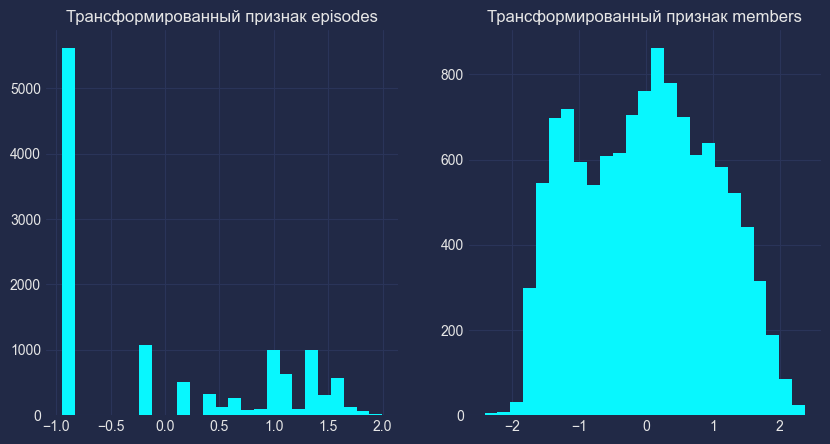

In [357]:
plt.figure(figsize=(10, 5))
# производим трансформацию распределения признака episodes в Гауссовое
plt.subplot(1, 2, 1)
data_transform = df['episodes'].values.reshape(len(df), 1)
# выбераем метод трансформации
power = preprocessing.PowerTransformer(method='box-cox') # используется пребразование бокса-Кокса, т.к. признак не имеет нулевых и отрицательных значений
power_pred = power.fit_transform(data_transform)
df['episodes'] = power_pred
plt.title('Трансформированный признак episodes')
plt.hist(power_pred, bins=25);
# производим трансформацию распределения признака members в Гауссовое
plt.subplot(1, 2, 2)
data_transform = df['members'].values.reshape(len(df), 1)
# выбераем метод трансформации
power = preprocessing.PowerTransformer(method='box-cox') # используется пребразование бокса-Кокса, т.к. признак не имеет нулевых и отрицательных значений
power_pred = power.fit_transform(data_transform)
df['members'] = power_pred
plt.title('Трансформированный признак members')
plt.hist(power_pred, bins=25);

Размерность матрицы: (53, 53)
Ранг матрицы: 52
Определитель матрицы: -2.0605797733336392e-18


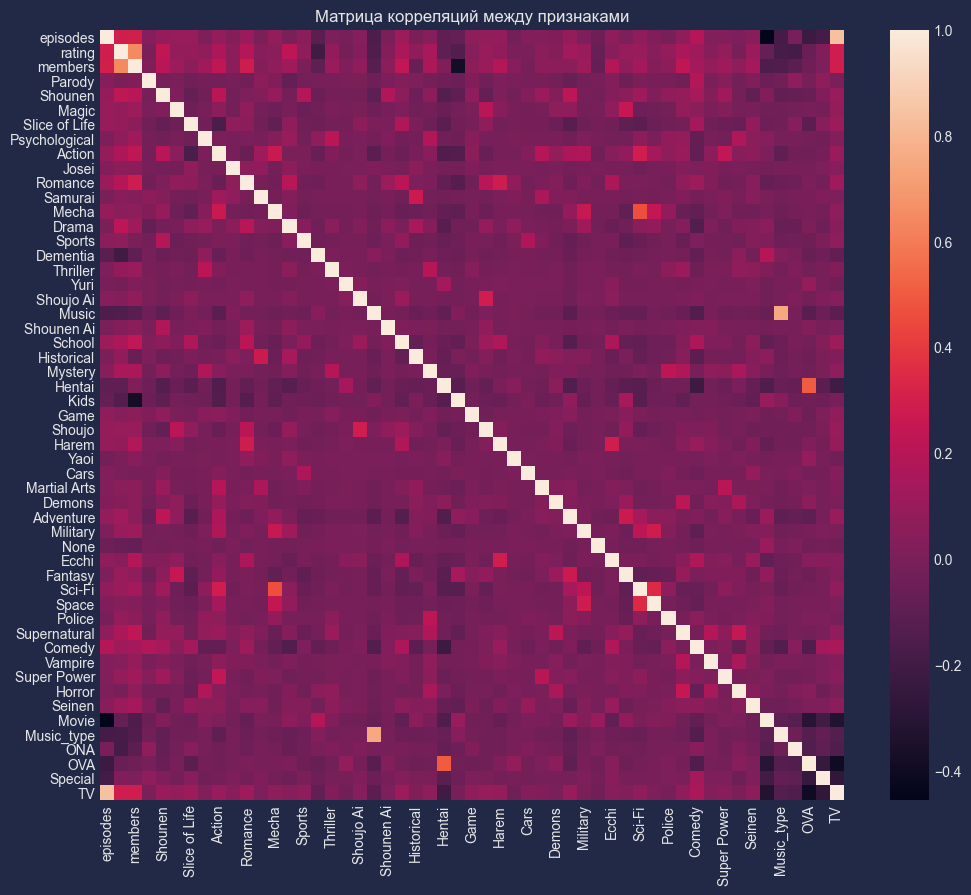

In [358]:
plt.figure(figsize=(12, 10))
sns.heatmap(data=df.corr())
plt.title('Матрица корреляций между признаками')
print('Размерность матрицы:', df.corr().shape)
print('Ранг матрицы:', np.linalg.matrix_rank(df.corr()))
print('Определитель матрицы:', np.linalg.det(df.corr()))

* Определитель матрицы слишком близок к 0. Матрица близка к вырождению.

In [359]:
df.drop('TV', axis=1, inplace=True) # удаляем высокоскоррелированный признак TV
print('Определитель матрицы:', np.linalg.det(df.corr())) # выводим определитель матрицы

Определитель матрицы: 0.00024912822280141056


In [360]:
# разделение данных на тестовые и тренировочные 
X = df.drop('rating', axis=1)
y = df['rating'] # выделение целевого признака
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25, random_state=42)

In [361]:
# производим отбор признаков методов рекурсивного исключения
estimator = linear_model.LinearRegression()
selector = feature_selection.RFE(estimator=estimator, step=1)
selector = selector.fit(X_train, y_train)
# создаём словарь с названием признаков и оценкой их важности
data_select = dict()
for i in zip(X_train.columns, selector.ranking_):
    data_select[i[0]] = i[1]
# сортровка полученного словаря по значению 
data_select = dict(sorted(data_select.items(), key=lambda x: x[1]))
print(data_select)
# удаление наименее важных признаков
df = df.drop(['Super Power', 'Magic'], axis=1)

{'episodes': 1, 'members': 1, 'Shounen': 1, 'Slice of Life': 1, 'Josei': 1, 'Drama': 1, 'Sports': 1, 'Dementia': 1, 'Yuri': 1, 'Shoujo Ai': 1, 'Shounen Ai': 1, 'Historical': 1, 'Mystery': 1, 'Hentai': 1, 'Kids': 1, 'Yaoi': 1, 'None': 1, 'Ecchi': 1, 'Police': 1, 'Horror': 1, 'Seinen': 1, 'Movie': 1, 'ONA': 1, 'OVA': 1, 'Special': 1, 'Adventure': 2, 'Vampire': 3, 'Shoujo': 4, 'Samurai': 5, 'Music_type': 6, 'Military': 7, 'School': 8, 'Cars': 9, 'Harem': 10, 'Mecha': 11, 'Parody': 12, 'Fantasy': 13, 'Demons': 14, 'Space': 15, 'Action': 16, 'Psychological': 17, 'Music': 18, 'Game': 19, 'Martial Arts': 20, 'Comedy': 21, 'Romance': 22, 'Supernatural': 23, 'Sci-Fi': 24, 'Thriller': 25, 'Magic': 26, 'Super Power': 27}


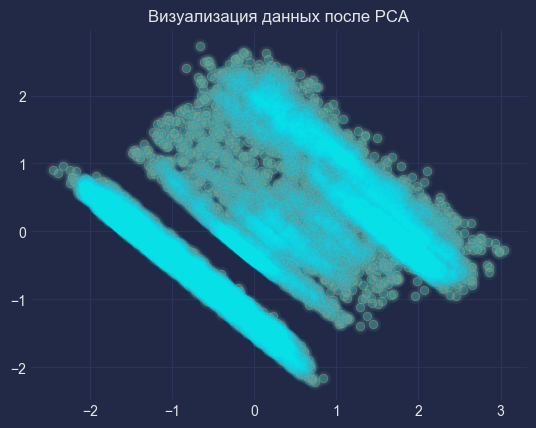

In [362]:
# понижаем размерность данных методом главных компонент
pca = decomposition.PCA(n_components=2)
X_pca = pca.fit_transform(X) # преобразование исходных данных
# визуализация данных после понижения размерности
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], alpha=0.3)
plt.title('Визуализация данных после PCA')
mplcyberpunk.make_scatter_glow(n_glow_lines=7, diff_dotwidth=1.2, alpha=0.3)

In [363]:
# обучение модели
model = linear_model.LinearRegression() # выбор модели линейной регрессии
# создаём объект кросс-валидатора KFold
kf = model_selection.KFold(n_splits=5, random_state=42, shuffle=True)
train_mape = list() # список для хранения тренировочных метрик
test_mape = list() # список для хранения тестовых метрик
# цикл для кросс-валидации
for train_index, test_index in kf.split(X, y):
    # создание тренировочной и тестовой выборки
    X_train, y_train = X.iloc[train_index], y.iloc[train_index]
    X_test, y_test = X.iloc[test_index], y.iloc[test_index]
    # обучение модели
    model.fit(X_train, y_train)
    # получение предсказаний для выборок
    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)
    # расчитываем метрики и добавляем в списки
    train_mape.append(metrics.mean_absolute_percentage_error(y_train, train_pred))
    test_mape.append(metrics.mean_absolute_percentage_error(y_test, test_pred))
print(np.mean(train_mape))
print(np.mean(test_mape))
# производим логирование результатов
logging.basicConfig(level=logging.INFO, filename='logging.log', filemode='a')
logging.info('Add KFold')
logging.info(f'{datetime.now()} MAPE (train): {np.mean(train_mape)}')
logging.info(f'{datetime.now()} MAPE (test): {np.mean(test_mape)}')

0.0872983303414703
0.0876666204883114


In [364]:
random_state = 42
model = tree.DecisionTreeRegressor()
kf = model_selection.KFold(n_splits=5, random_state=random_state, shuffle=True)
scoring = metrics.make_scorer(metrics.mean_absolute_percentage_error)
crossval = model_selection.cross_validate(estimator=model, X=X, y=y, scoring=scoring, cv=kf, return_train_score=True)
crossval

{'fit_time': array([0.04962087, 0.06390715, 0.04998064, 0.05024552, 0.04976344]),
 'score_time': array([0., 0., 0., 0., 0.]),
 'test_score': array([0.10722933, 0.10609616, 0.10677813, 0.10938439, 0.10840696]),
 'train_score': array([0.00378137, 0.00309224, 0.00330129, 0.00295874, 0.00332496])}

* Заметно явное переобучение модели. Необходимо подобрать оптимальные гиперпараметры.

In [365]:
grid = {'max_depth': np.linspace(2, 10, 9, dtype='int'),
        'min_samples_leaf': np.linspace(2, 10, 9, dtype='int'),
        'criterion': ['squared_error', 'friedman_mse', 'absolute_error', 'poisson']}
grid_search = model_selection.RandomizedSearchCV(estimator=tree.DecisionTreeRegressor(random_state=random_state), 
                                                 param_distributions=grid, n_iter=10, scoring=scoring, cv=kf, random_state=random_state)
grid_search.fit(X, y)
best = grid_search.best_params_
print(grid_search.best_params_)
grid_search.cv_results_['mean_test_score'].mean()

{'min_samples_leaf': 2, 'max_depth': 3, 'criterion': 'squared_error'}


0.08998453403370135

In [366]:
grid = {'n_estimators': np.linspace(50, 100, 20, dtype='int')}
grid_search = model_selection.RandomizedSearchCV(estimator=ensemble.RandomForestRegressor(random_state=random_state, min_samples_leaf=best['min_samples_leaf'], max_depth=best['max_depth'], criterion=best['criterion']), 
                                                 param_distributions=grid, n_iter=5, scoring=scoring, cv=kf, random_state=random_state)
grid_search.fit(X, y)
print(grid_search.best_params_)
grid_search.cv_results_['mean_test_score'].mean()

{'n_estimators': 50}


0.09507757000324613

In [367]:
grid = {'n_estimators': np.linspace(10, 100, 20, dtype='int'),
        'learning_rate': np.linspace(0.005, 0.1, 20),
        'loss': ['linear', 'square', 'exponential']}
grid_search = model_selection.RandomizedSearchCV(estimator=ensemble.AdaBoostRegressor(estimator=tree.DecisionTreeRegressor(random_state=random_state, min_samples_leaf=best['min_samples_leaf'], max_depth=best['max_depth'], criterion=best['criterion']), random_state=random_state), 
                                                 param_distributions=grid, n_iter=5, scoring=scoring, cv=kf, random_state=random_state)
grid_search.fit(X, y)
print(grid_search.best_params_)
grid_search.cv_results_['mean_test_score'].mean()

{'n_estimators': 81, 'loss': 'linear', 'learning_rate': 0.095}


0.09561753168128993